In [8]:
# Load required modules
import numpy as np
import cv2
import glob
import os
from scipy.signal import convolve2d
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

# Download and preprocess data

In [2]:
 ! svn export https://github.com/LabForComputationalVision/bias_free_denoising/trunk/data/Train400

In [2]:
path_to_image_data = 'Train400'
path_to_saved_models = './image_wavelet/saved_models/'

In [3]:
files_source = glob.glob(os.path.join(path_to_image_data, '*.png'))
files_source = np.sort(files_source)
list_of_image_path = files_source

In [26]:
resize_to_256 = True
n_data = len(list_of_image_path)

data_list = [None]*n_data;
for i in range(n_data):
    f = list_of_image_path[i];
    Img = cv2.imread(f)
    Img = np.float32(Img[:,:,0])/255.
    if resize_to_256:
        Img = cv2.resize(Img, (256, 256)) 
        data_list[i] = Img;

In [22]:
# Sample a 50 examples subset to reduce computation
random_batch = np.random.choice(range(len(data_list)), 50)
data_list = np.array(data_list)[random_batch]

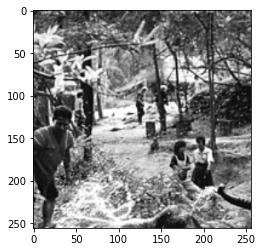

In [23]:
plt.imshow(data_list[0],cmap='gray')

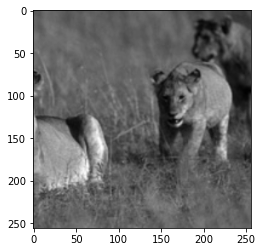

In [29]:
plt.imshow(data_list[6],cmap='gray')

# Theoretical Wiener Filter Loss

In [7]:
def get_noise(data, noise_std = 0.1, mode='S', max_noise = 5e-1):
    noise = np.random.randn(*data.shape);
    if mode == 'B':
        n = noise.shape[0];
        noise_tensor_array = max_noise * np.random.rand(n);
        for i in range(n):
            noise[i] = noise[i] * noise_tensor_array[i];
    else:
        noise = noise * noise_std;
    return noise

In [ ]:
def best_wiener_loss(dataset, noise_std, wiener_star, fft_sample= (180, 180)):
    mean_loss = 0;
    mean_psnr = 0;
    for source in dataset:
        noisy = source + get_noise(source, noise_std=noise_std)

        source_fft = np.fft.fftshift( np.fft.fft2(source, s = fft_sample) );
        noisy_fft = np.fft.fftshift( np.fft.fft2(noisy, s = fft_sample) );
        denoised_fft = noisy_fft * wiener_star;

        source_ifft = np.clip( np.real( np.fft.ifft2( np.fft.ifftshift(source_fft), s= fft_sample) ), 0., 1. );
        noisy_ifft = np.clip( np.real(np.fft.ifft2( np.fft.ifftshift( noisy_fft), s = fft_sample)), 0., 1. );
        denoised_ifft = np.clip( np.real( np.fft.ifft2( np.fft.ifftshift(denoised_fft), s = fft_sample)), 0., 1. );
        
        mean_loss += #np.sum((denoised_ifft - source_ifft)**2);
    
    return mean_loss/len(dataset)

In [8]:
def theoretical_wiener_from_data(train_dataset, noise_std, fft_shift = True, fft_sample = (256, 256),  n = 10):
    # Args: 
    #  train_dataset: data used to calculate wiener filter
    #  noise std: standard deviation to control noise level
    #  fftshift: shift the zero-frequency component to the center of the spectrum
    #  n: number of epochs
    
    # Pelase fill in the code
    mean_coeff = np.fft.fft2(train_dataset[0], s = fft_sample) * 0;
    for i in range(n):
        for x in train_dataset:
            'Fill here to get the sample wiener filter'
            

    mean_coeff /= n*len(train_dataset)
    if fft_shift:
        return np.fft.fftshift(mean_coeff)
    else:
        return mean_coeff
    

In [ ]:
# For different noise level, produce calculated wiener filter
noise_std_array = [float(10)/255, float(25)/255, float(55)/255];
wiener_star = {}
for noise_std in noise_std_array:
    print('noise level: ', noise_std)
    wiener_star[noise_std] = theoretical_wiener_from_data(data_list, noise_std, fft_shift = True, fft_sample = (256, 256),  n = 10)

In [ ]:
# Obtain loss values of the the winer filter on different noise level
for noise_std in noise_std_array:
    print('noise std: ', noise_std)
    wiener_star_loss = best_wiener_loss(data_list, noise_std, wiener_star[noise_std], fft_sample = (256, 256))
    print('Loss: ', wiener_star_loss)
    print('='*50 + '\n')

# Linear Model Optimization

In this section, we focus on a linear model to perform denoising.

The model is parmetrized by a filter $w$ and optimized by the loss function $\frac{1}{n} ||w*x_{noisy} - x_{clean} ||^2$

You will need the function: convolve2d(x_noisy, w, mode='same', boundary = 'wrap') to compute the convolution

In [16]:
n_data_points = len(data_list)

In [17]:

def loss(w, clean_dataset, noisy_dataset):
    # Args:
    #  w: filter with size usually 3*3 or 5*5
    #  clean version of dataset
    #  noisy version of dataset
    loss = 0;
    for (source, noisy) in zip(clean_dataset, noisy_dataset):
        w_2d = w.reshape( int(np.sqrt(len(w))), int(np.sqrt(len(w))) ) # reshapre filter to 2D
        "Fill here to comupte the loss for each instance and sum them up"
        
    return loss/len(clean_dataset)

In [ ]:
# set the size of the filter to 5*5
w_len = 5*5

In [ ]:
# Calculate initial loss

In [ ]:
w0_dict = {}
noisy_dataset = {}
for noise_std in noise_std_array:
    noisy_dataset[noise_std] = [source + get_noise(source, noise_std=noise_std) for source in data_list]
    w0_dict[noise_std] = np.random.randn(w_len)*0.001
    least_squre_loss = loss(w0_dict[noise_std], data_list[:n_data_points], noisy_dataset[noise_std][:n_data_points])
    print('Loss: ', least_squre_loss)
    print('='*50 + '\n')

In [ ]:
# Optimize the model
w = {}
for noise_std in noise_std_array:
    print('noise std: ', noise_std)
    
    w0 = w0_dict[noise_std]
    res = minimize(loss, w0, args = (data_list[:n_data_points], noisy_dataset[noise_std][:n_data_points]), method='SLSQP', tol=1e-6)
    w[noise_std] = res.x

## Please Compute the loss value on the optimized $w$, how does the loss value changes omparing with the random initialization, and with the loss of the theoretical wiener filter

# A simple nonlinear model

We define a simple nonlinear model as a composition of convolution, ReLU, convolution layers, and optimize this nonlinear model

In [13]:
def conv_relu_conv(big_w, noisy):
    #big_w: a big filter without reshape
    #noisy: noisy data
    #return the output of the model
    n = len(big_w)
    w1 = big_w[:n//2].reshape( int(np.sqrt(n//2)), int(np.sqrt(n//2))) # filter for the first convolution
    w2 =big_w[n//2:].reshape(int(np.sqrt(n//2)), int(np.sqrt(n//2))) # filter for the second convolution
    
    "fill here to implement the nonlinear model (for ReLU, you can implement it as f(x) = max(0,x), refer https://en.wikipedia.org/wiki/Rectifier_(neural_networks))"
    
    
    return out

In [ ]:
def loss_cnn(w, clean_dataset, noisy_dataset):
    mean_loss = 0;
    
    for (source, noisy) in zip(clean_dataset, noisy_dataset):
        
        mean_loss +=  np.sum((conv_relu_conv(w, noisy ) - source)**2);
        
    return mean_loss/len(clean_dataset)


In [14]:
w_len = 5*5*2

In [ ]:
# Calculate initial loss
w0_dict = {}
noisy_dataset = {}
for noise_std in noise_std_array:
    noisy_dataset[noise_std] = [source + get_noise(source, noise_std=noise_std) for source in data_list]
    w0_dict[noise_std] = np.random.randn(w_len)*0.001
    least_squre_loss = loss_cnn(w0_dict[noise_std], data_list[:n_data_points], noisy_dataset[noise_std][:n_data_points])
    print('Loss: ', least_squre_loss)
    print('='*50 + '\n')

In [ ]:
# Optimize the model
w = {}
for noise_std in noise_std_array:
    print('noise std: ', noise_std)
    
    w0 = w0_dict[noise_std]
    res = minimize(loss_cnn, w0, args = (data_list[:n_data_points], noisy_dataset[noise_std][:n_data_points]), method='SLSQP', tol=1e-6)
    w[noise_std] = res.x

In [ ]:
for noise_std in noise_std_array:
    print('noise std: ', noise_std)
    least_squre_loss = loss_cnn(w[noise_std], data_list[:n_data_points], noisy_dataset[noise_std][:n_data_points])
    print('Loss: ', least_squre_loss)

    print('='*50 + '\n')

## Please Compute the loss value of this nonlinear model on the optimized $w$, how does the loss value change comparing with the random initialization, with the linear model and with the loss of the theoretical wiener filter